<a href="https://colab.research.google.com/github/ulaim/6.7960-Final/blob/main/Deep_Learning_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets
!pip install torch torchvision torchaudio


!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu117.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu117.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu117.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.1+cu117.html
!pip install torch-geometric

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertForMultipleChoice
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 54.2 MB/s eta 0:00:00
Looking in links

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

In [ ]:
dataset = load_dataset('social_i_qa', trust_remote_code=True)

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.81k [00:00<?, ?B/s]

social_i_qa.py:   0%|          | 0.00/4.67k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1954 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
for i in range(25):
    question = dataset['train'][i]['question']
    print(f"{i+1}: {question}")


1: How would Others feel as a result?
2: What will Others want to do next?
3: What will Remy want to do next?
4: Why did Addison do this?
5: What does Kai need to do before this?
6: What does Quinn need to do before this?
7: What does Bailey need to do before this?
8: What will Kendall want to do next?
9: What will Quinn want to do next?
10: How would you describe Kendall?
11: How would you describe Sydney?
12: What will Aubrey want to do next?
13: What does Cameron need to do before this?
14: How would Jan feel afterwards?
15: What does Remy need to do before this?
16: Why did Austin do this?
17: How would you describe Jordan?
18: What will Ash want to do next?
19: Why did Bailey do this?
20: How would Sydney feel afterwards?
21: How would Bailey feel afterwards?
22: What does Sydney need to do before this?
23: How would Quinn feel afterwards?
24: What will Skylar want to do next?
25: How would you describe Remy?


In [ ]:
import re

def assign_question_type(question):
    question = question.lower()
    if re.match(r'what (will|would|does).* want to do', question):
        return 'wants'
    elif re.match(r'how (will|would|does) .* feel', question) or re.match(r'what (will|would|does) .* feel', question):
        return 'reactions'
    elif re.match(r'why (did|does) .*', question):
        return 'motivations'
    elif re.match(r'what (did|does) .* need ', question) or re.match(r'what should .* do', question):
        return 'needs'
    elif re.match(r'how (would|could) .* describe', question) or re.match(r'how (would|could) .* be described', question):
        return 'descriptions'
    elif re.match(r'what will happen', question) or re.match(r'what will .* do', question):
        return 'effects'
    else:
        return 'Other'


In [ ]:
def add_question_type(example):
    example['question_type'] = assign_question_type(example['question'])
    # if example['question_type'] == 'Other':
    #   print(example['question'])
    return example

dataset = dataset.map(add_question_type)


Map:   0%|          | 0/33410 [00:00<?, ? examples/s]

Map:   0%|          | 0/1954 [00:00<?, ? examples/s]

In [ ]:
from collections import Counter

question_types = [example['question_type'] for example in dataset['train']]
counter = Counter(question_types)
print(counter)



Counter({'wants': 8252, 'reactions': 7870, 'descriptions': 4998, 'motivations': 4550, 'needs': 4229, 'effects': 3081, 'Other': 430})


In [ ]:
def preprocess_function(examples):
    num_examples = len(examples["context"])
    labels = [int(label) - 1 for label in examples["label"]]

    choices_inputs = []
    for i in range(num_examples):
        context = examples["context"][i]
        question = examples["question"][i]
        choices = [examples["answerA"][i], examples["answerB"][i], examples["answerC"][i]]
        inputs = []
        question_types = examples['question_type']
        for choice in choices:
            text = context + " " + question + " " + choice
            inputs.append(text)
        choices_inputs.append(inputs)

    inputs = sum(choices_inputs, [])

    tokenized_inputs = tokenizer(
        inputs,
        truncation=True,
        padding='max_length',
        max_length=128,
    )

    input_ids = [tokenized_inputs['input_ids'][i:i + 3] for i in range(0, len(tokenized_inputs['input_ids']), 3)]
    attention_mask = [tokenized_inputs['attention_mask'][i:i + 3] for i in range(0, len(tokenized_inputs['attention_mask']), 3)]

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels, 'question_type': question_types}

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels', 'question_type'])

batch_size = 64

train_dataloader = DataLoader(encoded_dataset['train'], batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(encoded_dataset['validation'], batch_size=batch_size)

model_bert = BertForMultipleChoice.from_pretrained('bert-base-uncased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bert.to(device)

optimizer = AdamW(model_bert.parameters(), lr=1e-5, weight_decay=0.01)

epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model_bert.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels, output_attentions=True)
        loss = outputs.loss

        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    true_labels = []
    pred_labels_bert = []
    question_types = []

    model_bert.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    for batch in eval_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        question_types.extend(batch['question_type'])

        with torch.no_grad():
            outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels, output_attentions=True)
            loss = outputs.loss
            logits = outputs.logits

        total_eval_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels_bert.extend(predictions.cpu().numpy())
        total_eval_accuracy += (predictions == labels).sum().item()

    avg_val_loss = total_eval_loss / len(eval_dataloader)
    val_losses.append(avg_val_loss)

    avg_val_accuracy = total_eval_accuracy / len(encoded_dataset['validation'])
    val_accuracies.append(avg_val_accuracy)
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Average training loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {avg_val_accuracy:.4f}")


Map:   0%|          | 0/33410 [00:00<?, ? examples/s]

Map:   0%|          | 0/1954 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation=

Epoch 1/3
Average training loss: 0.8557
Validation Loss: 0.9740
Validation Accuracy: 0.5455
Epoch 2/3
Average training loss: 0.6840
Validation Loss: 0.9502
Validation Accuracy: 0.5798
Epoch 3/3
Average training loss: 0.6179
Validation Loss: 0.9552
Validation Accuracy: 0.5814


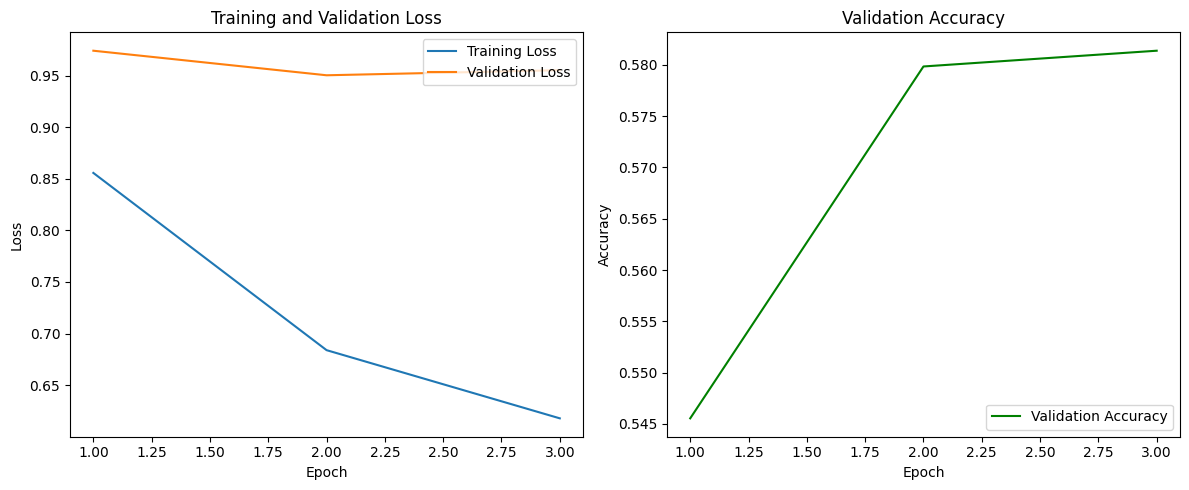

In [ ]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
def extract_unique_words(dataset):
    unique_words = set()
    for split in ['train', 'validation']:
        for example in dataset[split]:
            text = example['context'] + " " + example['question'] + " " + example['answerA'] + " " + example['answerB'] + " " + example['answerC']
            tokens = tokenizer.tokenize(text)
            tokens = [token.replace('##', '') for token in tokens]
            unique_words.update(tokens)
    return unique_words

unique_words = extract_unique_words(dataset)
print(f"Number of unique tokens: {len(unique_words)}")

Number of unique tokens: 12710


In [ ]:
concepts_to_load = set()
for word in unique_words:
    concept = '/c/en/' + word.lower()
    concepts_to_load.add(concept)

In [ ]:
!wget -O numberbatch-19.08.txt.gz https://conceptnet.s3.amazonaws.com/downloads/2019/numberbatch/numberbatch-19.08.txt.gz
!gunzip numberbatch-19.08.txt.gz

def load_numberbatch_embeddings(embedding_file, concepts_to_load):
    embeddings = {}
    with open(embedding_file, 'r', encoding='utf-8') as f:
        first_line = f.readline()
        num_vectors, dim = map(int, first_line.strip().split())
        print(f"Number of vectors: {num_vectors}, Dimension: {dim}")
        for line in f:
            tokens = line.rstrip().split(' ')
            word = tokens[0]
            if word in concepts_to_load:
                vector = np.array(tokens[1:], dtype=np.float32)
                embeddings[word] = vector
    return embeddings

numberbatch_embeddings = load_numberbatch_embeddings('numberbatch-19.08.txt', concepts_to_load)


--2024-12-07 17:51:06--  https://conceptnet.s3.amazonaws.com/downloads/2019/numberbatch/numberbatch-19.08.txt.gz
Resolving conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)... 3.5.25.39, 52.217.231.81, 52.216.217.129, ...
Connecting to conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)|3.5.25.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3191580656 (3.0G) [application/x-gzip]
Saving to: ‘numberbatch-19.08.txt.gz’

numberbatch-19.08.t 100%[===================>]   2.97G  48.8MB/s    in 65s     

2024-12-07 17:52:12 (46.8 MB/s) - ‘numberbatch-19.08.txt.gz’ saved [3191580656/3191580656]

Number of vectors: 9161912, Dimension: 300


In [ ]:
concept2id = {concept: idx for idx, concept in enumerate(concepts_to_load)}
id2concept = {idx: concept for concept, idx in concept2id.items()}


In [ ]:
!wget -O conceptnet-assertions-5.7.0.csv.gz https://s3.amazonaws.com/conceptnet/downloads/2019/edges/conceptnet-assertions-5.7.0.csv.gz
!gunzip conceptnet-assertions-5.7.0.csv.gz

import csv

def load_conceptnet_edges(edge_file, concept2id):
    edges = []
    with open(edge_file, 'r', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:

            if len(row) != 5:
                continue

            _, rel, start, end, _ = row

            if not (start.startswith('/c/en/') and end.startswith('/c/en/')):
                continue

            if start in concept2id and end in concept2id:
                start_id = concept2id[start]
                end_id = concept2id[end]
                edges.append((start_id, end_id))
                edges.append((end_id, start_id))
    return edges

--2024-12-07 17:56:45--  https://s3.amazonaws.com/conceptnet/downloads/2019/edges/conceptnet-assertions-5.7.0.csv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.230.88, 52.216.88.29, 52.217.233.232, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.230.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 497963447 (475M) [application/x-gzip]
Saving to: ‘conceptnet-assertions-5.7.0.csv.gz’

conceptnet-assertio 100%[===================>] 474.89M  88.4MB/s    in 5.4s    

2024-12-07 17:56:51 (87.4 MB/s) - ‘conceptnet-assertions-5.7.0.csv.gz’ saved [497963447/497963447]



In [ ]:
edges = load_conceptnet_edges('conceptnet-assertions-5.7.0.csv', concept2id)
print(f"Number of edges: {len(edges)}")

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

feat_dim = next(iter(numberbatch_embeddings.values())).shape[0]
node_feats = np.zeros((len(concept2id), feat_dim), dtype=np.float32)
for concept, idx in concept2id.items():
    if concept in numberbatch_embeddings:
        node_feats[idx] = numberbatch_embeddings[concept]
    else:
        node_feats[idx] = np.random.normal(size=(feat_dim,))

x = torch.tensor(node_feats, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)

Number of edges: 192110


In [ ]:
class ConceptNetGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ConceptNetGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [ ]:
gnn_model = ConceptNetGNN(in_channels=feat_dim, hidden_channels=128, out_channels=128)


In [ ]:
def preprocess_function(examples):
    num_examples = len(examples["context"])
    labels = [int(label) - 1 for label in examples["label"]]

    choices_inputs = []
    concept_ids_list = []

    for i in range(num_examples):
        context = examples["context"][i]
        question = examples["question"][i]
        choices = [examples["answerA"][i], examples["answerB"][i], examples["answerC"][i]]
        inputs = []
        question_types = examples['question_type']
        choice_concept_ids = []

        for choice in choices:
            text = context + " " + question + " " + choice
            inputs.append(text)

            tokens = tokenizer.tokenize(text)
            tokens = [token.replace('##', '') for token in tokens]
            tokens = [token.lower() for token in tokens]
            concepts = ['/c/en/' + token for token in tokens if '/c/en/' + token in concept2id]
            ids = [concept2id[concept] for concept in concepts]
            choice_concept_ids.append(ids)

        choices_inputs.append(inputs)
        concept_ids_list.append(choice_concept_ids)

    inputs = sum(choices_inputs, [])
    tokenized_inputs = tokenizer(
        inputs,
        truncation=True,
        padding='max_length',
        max_length=128,
    )

    input_ids = [tokenized_inputs['input_ids'][i:i + 3] for i in range(0, len(tokenized_inputs['input_ids']), 3)]
    attention_mask = [tokenized_inputs['attention_mask'][i:i + 3] for i in range(0, len(tokenized_inputs['attention_mask']), 3)]

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
        'concept_ids': concept_ids_list,
        'question_type': question_types
    }


In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

def convert_to_tensors(examples):
    examples['concept_ids'] = [
        [
            torch.tensor(ids, dtype=torch.long) if len(ids) > 0 else torch.tensor([-1], dtype=torch.long)
            for ids in choice_ids
        ]
        for choice_ids in examples['concept_ids']
    ]
    return examples

encoded_dataset = encoded_dataset.map(convert_to_tensors, batched=True)

encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels', 'concept_ids', 'question_type'])

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['labels'] for item in batch])
    question_types = [item['question_type'] for item in batch]

    max_num_concepts = 0
    for item in batch:
        for choice_ids in item['concept_ids']:
            if len(choice_ids) > max_num_concepts:
                max_num_concepts = len(choice_ids)

    batch_size = len(batch)
    num_choices = len(batch[0]['concept_ids'])

    concept_ids = torch.full((batch_size, num_choices, max_num_concepts), fill_value=-1, dtype=torch.long)

    for i, item in enumerate(batch):
        for j, choice_ids in enumerate(item['concept_ids']):
            length = len(choice_ids)
            if length > 0:
                concept_ids[i, j, :length] = choice_ids

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
        'concept_ids': concept_ids,
        'question_type': question_types
    }



Map:   0%|          | 0/33410 [00:00<?, ? examples/s]

Map:   0%|          | 0/1954 [00:00<?, ? examples/s]

Map:   0%|          | 0/33410 [00:00<?, ? examples/s]

Map:   0%|          | 0/1954 [00:00<?, ? examples/s]

In [ ]:
batch_size = 8

train_dataloader = DataLoader(
    encoded_dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
eval_dataloader = DataLoader(
    encoded_dataset['validation'], batch_size=batch_size, collate_fn=collate_fn
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BertWithConceptNet(nn.Module):
    def __init__(self, model_name, concept_emb_size, gnn_model):
        super(BertWithConceptNet, self).__init__()
        self.bert = BertModel.from_pretrained(model_name, output_attentions=False)
        self.gnn_model = gnn_model
        self.dropout = nn.Dropout(0.1)
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Linear(hidden_size + concept_emb_size, 1)

    def forward(self, input_ids, attention_mask, concept_ids, labels=None, return_combined_output=False):
        batch_size, num_choices, seq_length = input_ids.shape

        input_ids = input_ids.view(-1, seq_length)
        attention_mask = attention_mask.view(-1, seq_length)

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
        pooled_output = outputs.pooler_output
        attentions = outputs.attentions

        x = data.x.to(device)
        edge_index = data.edge_index.to(device)
        all_embeddings = self.gnn_model(x, edge_index)

        concept_ids = concept_ids.view(batch_size * num_choices, -1)
        concept_embeddings = []
        for ids in concept_ids:
            ids = ids[ids != -1]
            if len(ids) > 0:
                ids = ids.to(device)
                selected_embeddings = all_embeddings[ids]
                avg_embedding = selected_embeddings.mean(dim=0)
            else:
                avg_embedding = torch.zeros(self.gnn_model.conv2.out_channels).to(device)
            concept_embeddings.append(avg_embedding)
        concept_embeddings = torch.stack(concept_embeddings)

        combined_output = torch.cat((pooled_output, concept_embeddings), dim=1)
        combined_output = self.dropout(combined_output)
        logits = self.classifier(combined_output)
        reshaped_logits = logits.view(-1, num_choices)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(reshaped_logits, labels)

        if return_combined_output:
            return {'loss': loss, 'logits': reshaped_logits, 'combined_output': combined_output.cpu()}

        return {'loss': loss, 'logits': reshaped_logits, 'attentions': attentions}



In [ ]:
concept_emb_size = 128
gnn_model.to(device)
model_gnn = BertWithConceptNet('bert-base-uncased', concept_emb_size, gnn_model)
model_gnn.to(device)

from torch.optim import AdamW
optimizer = AdamW(model_gnn.parameters(), lr=1e-5, weight_decay=0.01)
epochs = 3
total_steps = len(train_dataloader) * epochs
from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model_gnn.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        concept_ids = batch['concept_ids']

        outputs = model_gnn(input_ids=input_ids, attention_mask=attention_mask, concept_ids=concept_ids, labels=labels)
        loss = outputs['loss']

        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}")


    true_labels = []
    pred_labels_gnn = []
    question_types = []

    model_gnn.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in eval_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        concept_ids = batch['concept_ids']
        question_types.extend(batch['question_type'])

        with torch.no_grad():
            outputs = model_gnn(input_ids=input_ids, attention_mask=attention_mask, concept_ids=concept_ids, labels=labels)
            loss = outputs['loss']
            logits = outputs['logits']

        total_eval_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels_gnn.extend(predictions.cpu().numpy())
        total_eval_accuracy += (predictions == labels).sum().item()

    avg_val_loss = total_eval_loss / len(eval_dataloader)
    avg_val_accuracy = total_eval_accuracy / len(encoded_dataset['validation'])

    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {avg_val_accuracy:.4f}")

Epoch 1/3, Training Loss: 0.7508
Validation Loss: 0.9034
Validation Accuracy: 0.6013
Epoch 2/3, Training Loss: 0.5405
Validation Loss: 0.9059
Validation Accuracy: 0.6331
Epoch 3/3, Training Loss: 0.4135
Validation Loss: 0.9987
Validation Accuracy: 0.6351


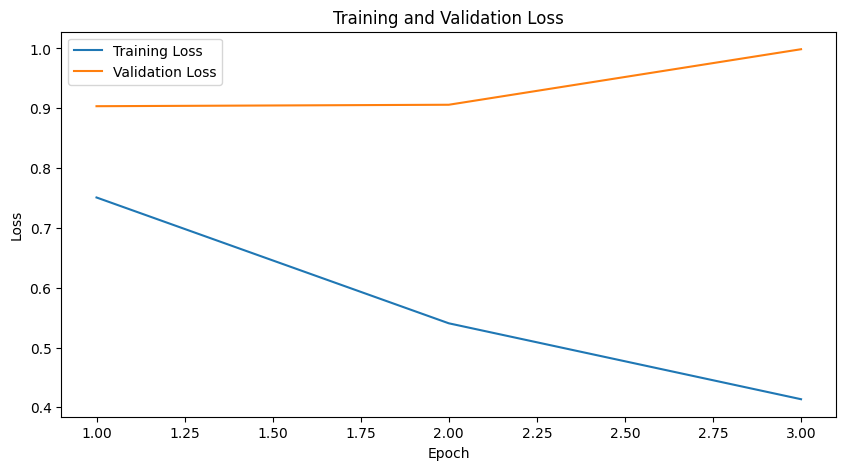

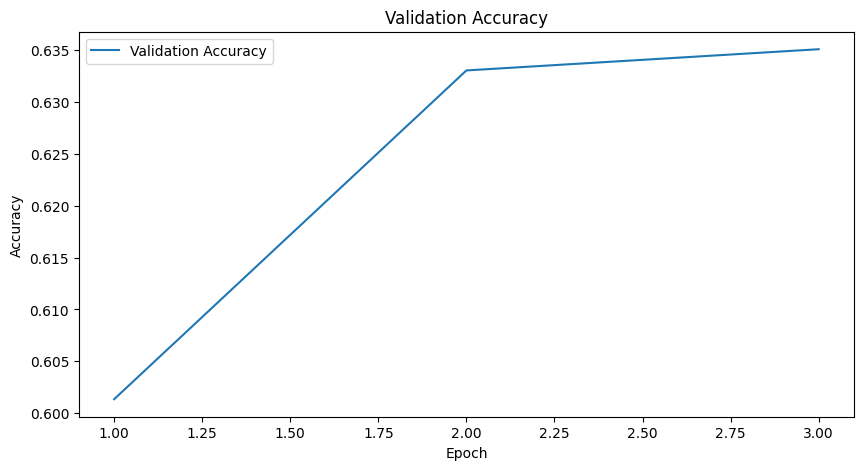

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

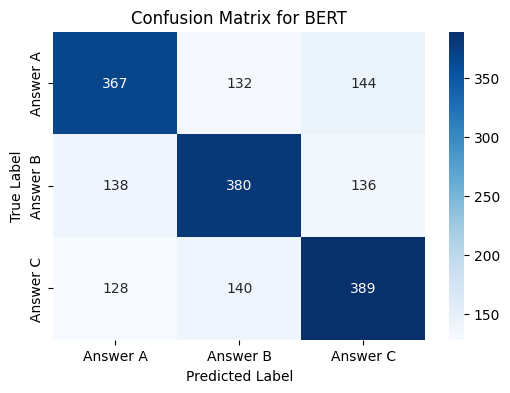

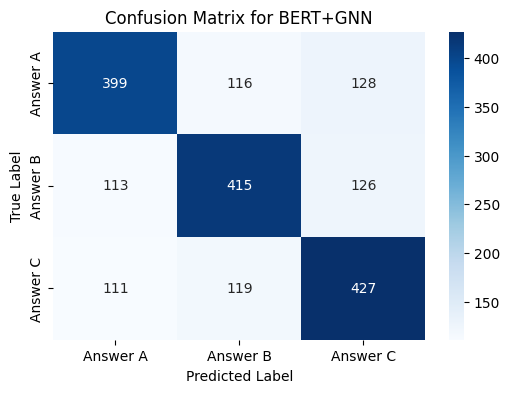

In [ ]:
def plot_confusion_matrix(true_labels, pred_labels, model_name):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Answer A', 'Answer B', 'Answer C'],
                yticklabels=['Answer A', 'Answer B', 'Answer C'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

plot_confusion_matrix(true_labels, pred_labels_bert, 'BERT')
plot_confusion_matrix(true_labels, pred_labels_gnn, 'BERT+GNN')


In [ ]:
errors_both = []
errors_bert_only = []
errors_gnn_only = []

for i, (true_label, pred_bert, pred_gnn) in enumerate(zip(true_labels, pred_labels_bert, pred_labels_gnn)):
    if pred_bert != true_label and pred_gnn != true_label:
        errors_both.append(i)
    elif pred_bert != true_label and pred_gnn == true_label:
        errors_bert_only.append(i)
    elif pred_bert == true_label and pred_gnn != true_label:
        errors_gnn_only.append(i)

print(f"Number of errors made by both models: {len(errors_both)}")
print(f"Number of errors made only by BERT: {len(errors_bert_only)}")
print(f"Number of errors made only by BERT+GNN: {len(errors_gnn_only)}")


Number of errors made by both models: 598
Number of errors made only by BERT: 220
Number of errors made only by BERT+GNN: 115


In [ ]:
from collections import defaultdict

def calculate_accuracy_per_type(true_labels, pred_labels, question_types):
    correct_per_type = defaultdict(int)
    total_per_type = defaultdict(int)

    for true_label, pred_label, q_type in zip(true_labels, pred_labels, question_types):
        total_per_type[q_type] += 1
        if true_label == pred_label:
            correct_per_type[q_type] += 1

    accuracy_per_type = {q_type: correct_per_type[q_type] / total_per_type[q_type]
                         for q_type in total_per_type}
    return accuracy_per_type

accuracy_per_type_bert = calculate_accuracy_per_type(true_labels, pred_labels_bert, question_types)
accuracy_per_type_gnn = calculate_accuracy_per_type(true_labels, pred_labels_gnn, question_types)


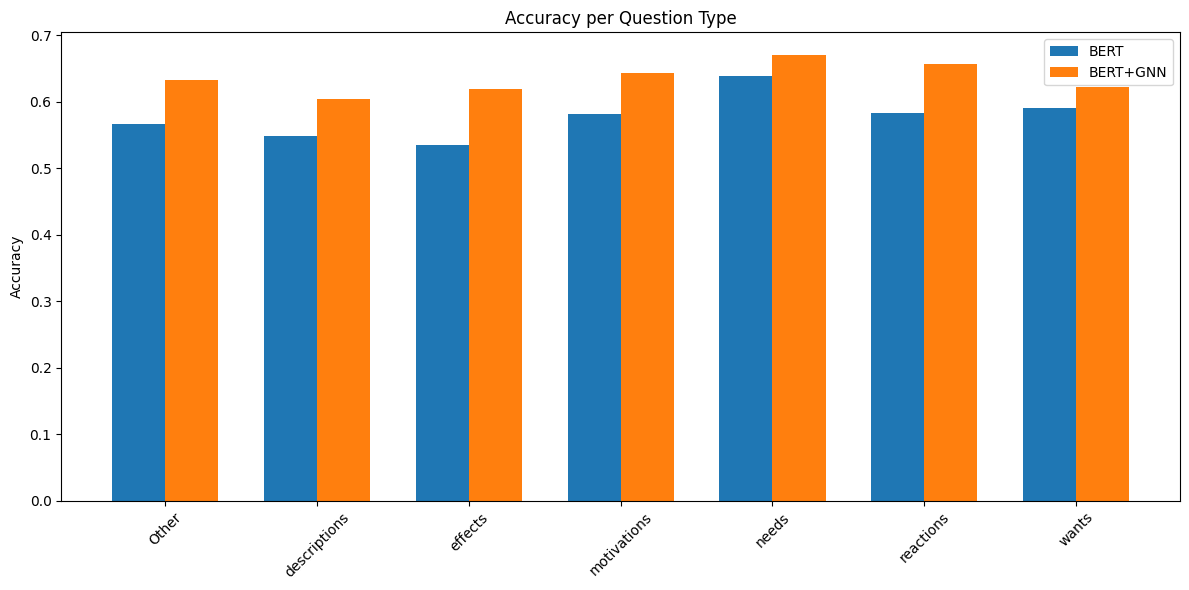

In [ ]:
types = list(set(question_types))
types.sort()

bert_accuracies = [accuracy_per_type_bert.get(t, 0) for t in types]
gnn_accuracies = [accuracy_per_type_gnn.get(t, 0) for t in types]

x = np.arange(len(types))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, bert_accuracies, width, label='BERT')
plt.bar(x + width/2, gnn_accuracies, width, label='BERT+GNN')
plt.xticks(x, types, rotation=45)
plt.ylabel('Accuracy')
plt.title('Accuracy per Question Type')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(bert_accuracies)
print(gnn_accuracies)
ratios = []
for i in range(len(bert_accuracies)):
    ratios.append(gnn_accuracies[i] / bert_accuracies[i])
print(ratios)


[0.5666666666666667, 0.548951048951049, 0.5352112676056338, 0.5819672131147541, 0.6396396396396397, 0.583743842364532, 0.5913200723327305]
[0.6333333333333333, 0.6048951048951049, 0.6197183098591549, 0.6434426229508197, 0.6711711711711712, 0.6576354679802956, 0.6220614828209765]
[1.1176470588235294, 1.1019108280254777, 1.1578947368421053, 1.1056338028169015, 1.0492957746478873, 1.1265822784810127, 1.0519877675840978]


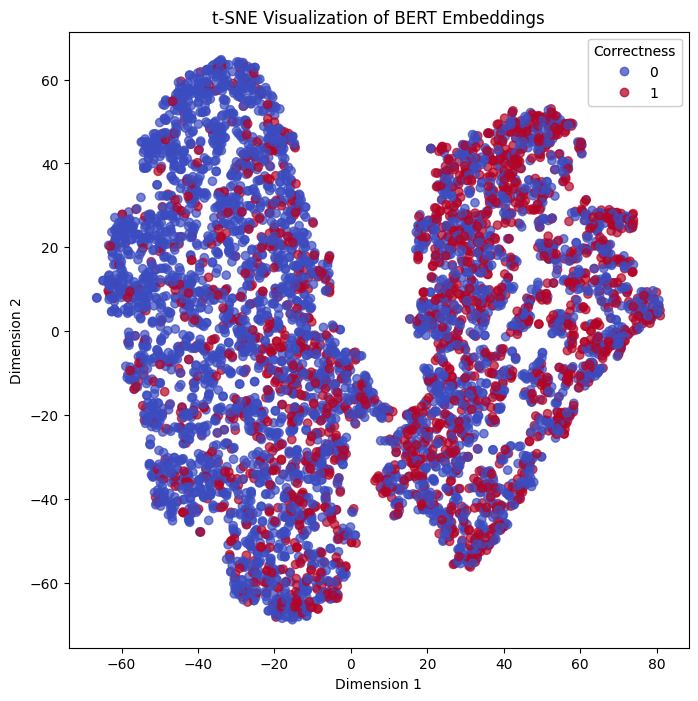

In [ ]:
from sklearn.manifold import TSNE

bert_embeddings = []
bert_labels = []

model_bert.eval()
for batch in eval_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].cpu().numpy()

    with torch.no_grad():
        outputs = model_bert.bert(input_ids.view(-1, input_ids.size(-1)),
                                  attention_mask=attention_mask.view(-1, input_ids.size(-1)))
        pooled_output = outputs.pooler_output.cpu().numpy()

    bert_embeddings.append(pooled_output)

    for lbl in labels:
        for choice_idx in range(3):
            bert_labels.append(1 if choice_idx == lbl else 0)

bert_embeddings = np.concatenate(bert_embeddings, axis=0)
bert_labels = np.array(bert_labels)

tsne = TSNE(n_components=2, random_state=42)
bert_embeddings_2d = tsne.fit_transform(bert_embeddings)

plt.figure(figsize=(8,8))
scatter = plt.scatter(bert_embeddings_2d[:,0], bert_embeddings_2d[:,1], c=bert_labels, cmap='coolwarm', alpha=0.7)
legend1 = plt.legend(*scatter.legend_elements(), title="Correctness")
plt.gca().add_artist(legend1)
plt.title('t-SNE Visualization of BERT Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


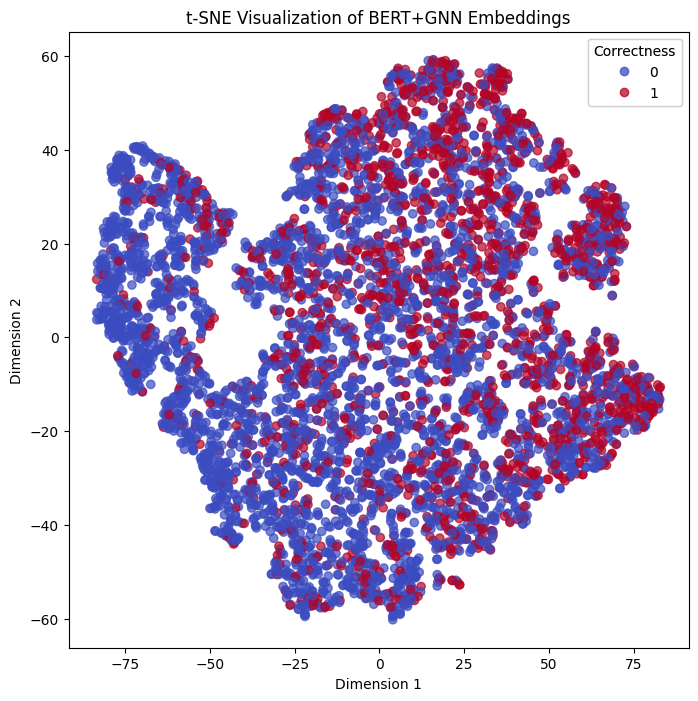

In [ ]:
model_gnn.eval()
gnn_embeddings = []
gnn_labels = []

for batch in eval_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].cpu().numpy()
    concept_ids = batch['concept_ids']

    with torch.no_grad():
        outputs = model_gnn(input_ids=input_ids,
                            attention_mask=attention_mask,
                            concept_ids=concept_ids,
                            return_combined_output=True)
        combined_output = outputs['combined_output'].numpy()

    gnn_embeddings.append(combined_output)

    for lbl in labels:
        for choice_idx in range(3):
            gnn_labels.append(1 if choice_idx == lbl else 0)

gnn_embeddings = np.concatenate(gnn_embeddings, axis=0)
gnn_labels = np.array(gnn_labels)

tsne = TSNE(n_components=2, random_state=42)
gnn_embeddings_2d = tsne.fit_transform(gnn_embeddings)

plt.figure(figsize=(8,8))
scatter = plt.scatter(gnn_embeddings_2d[:,0], gnn_embeddings_2d[:,1], c=gnn_labels, cmap='coolwarm', alpha=0.7)
legend1 = plt.legend(*scatter.legend_elements(), title="Correctness")
plt.gca().add_artist(legend1)
plt.title('t-SNE Visualization of BERT+GNN Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()
